# SUITS Overused phrases

<img src="images/suits.png" width="400px" />

Whoever has watched enough of the TV show [Suits](https://www.imdb.com/title/tt1632701/) knows that there are specific phrases repeated over and over in many episodes. Not only that but these phrases are used by many characters, as if they all have the same way of talking.  

Feeling the urge to quantify this observation, this notebook downloads, parses and analyses all the subtitles from all **134 episodes** (9 seasons) of Suits. It uses n-grams to assit finding common phrases and regular expressions to match them and similar ones in the subtitles corpus.

Sources of inspiration and common phrases:
- [Reddit post 1](https://www.reddit.com/r/suits/comments/grr7rv/overused_phrases_in_suits/)
- [Reddit post 2](https://www.reddit.com/r/suits/comments/44bzdx/most_used_phrases_in_suits/)
- [Reddit post 3](https://www.reddit.com/r/suits/comments/8npigk/can_we_compile_a_list_of_overused_suits_phrases/)
- [Reddit post 4](https://www.reddit.com/r/suits/comments/60iur6/goddamn_word_count/)

In [1]:
from collections import Counter

from bs4 import BeautifulSoup
import requests
import pandas as pd
from nltk import ngrams
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np

## 1. Walk though paginated list of URLs to transcripts
![](images/transcripts-webpage.png)

In [2]:
base_url = "https://tvshowtranscripts.ourboard.org"

In [3]:
episodes_page_0 = requests.get(
    base_url + "/viewforum.php?f=189",
    headers={
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.102 Safari/537.36"
    }).text

episodes_soup = BeautifulSoup(episodes_page_0, "html.parser")

### Links to episodes lists

In [4]:
paginated_episodes_urls = [x["href"] for x in episodes_soup.select("b.pagination")[0].findChildren("a")][0:-1]
paginated_episodes_urls = [base_url + "/viewforum.php?f=189"] + [base_url + x[1:] for x in paginated_episodes_urls]
paginated_episodes_urls

['https://tvshowtranscripts.ourboard.org/viewforum.php?f=189',
 'https://tvshowtranscripts.ourboard.org/viewforum.php?f=189&sid=689bf73ef643fcc249b56c1163d544ac&start=25',
 'https://tvshowtranscripts.ourboard.org/viewforum.php?f=189&sid=689bf73ef643fcc249b56c1163d544ac&start=50',
 'https://tvshowtranscripts.ourboard.org/viewforum.php?f=189&sid=689bf73ef643fcc249b56c1163d544ac&start=75',
 'https://tvshowtranscripts.ourboard.org/viewforum.php?f=189&sid=689bf73ef643fcc249b56c1163d544ac&start=100',
 'https://tvshowtranscripts.ourboard.org/viewforum.php?f=189&sid=689bf73ef643fcc249b56c1163d544ac&start=125']

In [5]:
anchors_to_subs = []
for url in paginated_episodes_urls:
    episodes_page = requests.get(
        url,
        headers={
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.102 Safari/537.36"
        }).text
    
    episodes_soup = BeautifulSoup(episodes_page, "html.parser")
    
    anchors_to_subs.extend(episodes_soup.select("a.topictitle"))

In [6]:
len(anchors_to_subs)

134

In [8]:
urls_to_subs = [base_url + x["href"][1:] for x in anchors_to_subs]

## 2. Visit each episode's page and collect transcripts

In [189]:
doc = []

for url in urls_to_subs:
    episode_page = requests.get(
        url,
        headers={
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.102 Safari/537.36"
        }).text
    
    episode_soup = BeautifulSoup(episode_page, "html.parser")
    # text = list(map(lambda x: x.text, episode_soup.select("div.postbody > p")))
    text = list(map(lambda x: x.text, episode_soup.select("p")))
    text = list(filter(lambda x: x[0] != "[", text))
    
    header = episode_soup.select("div.t-header.clearfix > div.pull-left > a")[0].text
    season_episode = header.split(" - ")[0]
    season, episode = season_episode.split("x")
    season, episode = int(season), int(episode)
    title = header.split(" - ")[1]
    
    print(f"{season} x {episode}                ", end="\r")
    
    doc.append({
        "season": season,
        "episode": episode,
        "title": title,
        "text": text
    })

In [190]:
len(doc)

134

### Some preprocessing

In [191]:
for d in doc:
    d["text"] = list(map(str.lower, d["text"]))

In [192]:
df = pd.DataFrame(doc)

In [193]:
df = df.explode("text")

In [194]:
df = df[~df["text"].str.contains("♪")]  # Remove song lyrics
df = df[~df["text"].str.contains("\(")]  # Remove non dialog text
df = df[~df["text"].str.contains("\)")]

In [195]:
df = df.reset_index().drop("index", axis=1)

In [196]:
df.head()

,season,episode,title,text
0,1,1,Pilot,transcripts » tv show transcripts » s » suits
1,1,1,Pilot,gerald tate's here.
2,1,1,Pilot,he wants to know what's happening to his deal.
3,1,1,Pilot,go get harvey.
4,1,1,Pilot,i check.


## 3. Extract most common phrases and their counts

### Most common N-grams

In [210]:
all_text = " ".join(df["text"].values.tolist())

In [211]:
ngram_counts = Counter(ngrams(all_text.split(), 3))
ngram_counts.most_common(10)

[(('what', 'are', 'you'), 965),
 (('what', 'do', 'you'), 723),
 (('you', 'want', 'to'), 606),
 (('i', 'want', 'to'), 455),
 (('i', "don't", 'want'), 454),
 (('what', 'the', 'hell'), 450),
 (('i', "don't", 'know'), 444),
 (('are', 'you', 'talking'), 420),
 (('you', 'talking', 'about?'), 410),
 (("don't", 'want', 'to'), 400)]

### All common phrases
These are extracted from reddit posts (see top cell), personal memories and most common n-grams  
Some are in Regular Expression form to match similar phrases

In [212]:
common_phrases = [
    "what did you just say",
    "that's enough",
    "you're goddamn right",
    "not now",
    "whatever it is.*wait",
    "that's funny because",
    "you better (?!than)",
    "(?:they|i|you|we|she|he) might as well",
    "goddamn it",
    "why are you telling me",
    "listen to me",
    "and you know it",
    "you son of a bitch",
    "we had a deal",
    "piece of sh",
    "i don't give a sh",
    "what now",
    "whatever it is, ",
    "you have my word",
    "like i said",
    "i'm done (?:\w+ing|with)",
    "don't (?:want to|wanna) talk about it",
    "wait a minute",
    "now[,]{0,1} if you'll excuse me",
    "what (?:the hell|)are you doing here",
    "what (?:the hell|)are you talking about",
    "(?:look|looked) me in the eye",
    "let me get this straight",
    "stay the hell away from",
    "you gave me your word",
    "let me guess",
    "come all the way",
    "what can i do for you",
    "what do you want me to say",
    "in the first place",
    "in the middle of something",
    "whatever it takes",
    "as far as i'm concerned",
    "what's that supposed to mean"
]

In [213]:
common_phrases_df = pd.DataFrame({"phrase": common_phrases, "count": 0, "n_episodes": 0})

for phrase in common_phrases:
    rows_with_phrase = df[df["text"].str.contains(phrase)]
    
    common_phrases_df.loc[common_phrases_df["phrase"] == phrase, "count"] = rows_with_phrase.shape[0]
    common_phrases_df.loc[common_phrases_df["phrase"] == phrase, "n_episodes"] = rows_with_phrase["episode"].nunique()

In [214]:
common_phrases_df["count_per_episode"] = common_phrases_df["count"] / common_phrases_df["n_episodes"]

In [215]:
common_phrases_df = common_phrases_df.sort_values(by="count", ascending=False)
common_phrases_df

,phrase,count,n_episodes,count_per_episode
25,what (?:the hell|)are you talking about,319,16,19.937500
34,in the first place,317,16,19.812500
10,listen to me,268,16,16.750000
24,what (?:the hell|)are you doing here,260,16,16.250000
15,i don't give a sh,181,16,11.312500
6,you better (?!than),175,16,10.937500
11,and you know it,140,16,8.750000
30,let me guess,122,16,7.625000
1,that's enough,94,16,5.875000
32,what can i do for you,90,16,5.625000


## 4. Visualize phrase count per season

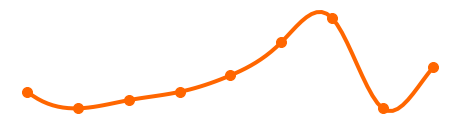

In [236]:
ts = df[df["text"].str.contains("what did you just say")].groupby("season")["text"].count()
ts = ts.reindex(range(1, 11)).fillna(0.0)

fig, ax = plt.subplots(figsize=(8, 2))
color = "#FF6600"

ax.plot(np.arange(1, 9.1, 0.1), interp1d(ts.index.values, ts.values, kind='cubic')(np.arange(1, 9.1, 0.1)),
        c=color, linewidth=4)
ax.scatter(ts.index[:-1], ts.values[:-1], c=color, s=100)

ax.axis("off")
ax.set_facecolor((0.0, 0.0, 0.0, 0.0))
fig.show()